### VectorStore

VectorStore는 자연어 --> 숫자 처리한 후 이들을 저장하는 벡터 저장소입니다.

벡터 저장소는 임베딩된 데이터를 인덱싱하여, input으로 받아들이는 query와의 유사도를 빠르게 출력합니다.

대표적으로 FAISS, Chroma가 존재합니다.

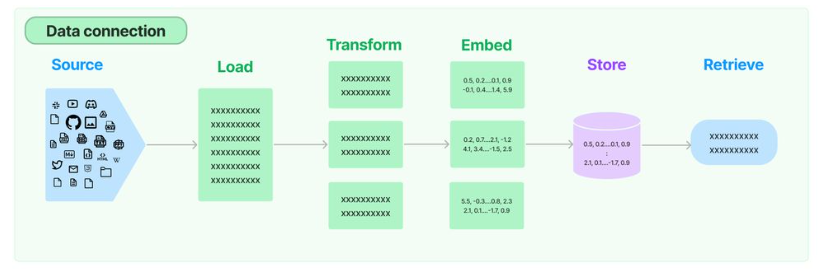

#### Chroma

Chroma는 대표적인 오픈소스 벡터 저장소입니다.

In [10]:
!pip install -q chromadb tiktoken transformers sentence_transformers openai langchain pypdf

기본적으로 VectorStore는 벡터를 **일시적으로** 저장합니다. 텍스트와 임베딩 함수를 지정하여 from_documents() 함수에 보내면, 지정된 임베딩 함수를 통해 텍스트를 벡터로 변환하고, 이를 임시 db로 생성합니다.

그리고 similarity_search() 함수에 쿼리를 지정해주면 이를 바탕으로 가장 벡터 유사도가 높은 벡터를 찾고 이를 자연어 형태로 출력합니다.

In [6]:
import tiktoken # 토크나이저와 관련된 작업을 위한 라이브러리
from langchain.text_splitter import RecursiveCharacterTextSplitter # Langchain에서 텍스트를 나누는 클래스 임포트

tokenizer = tiktoken.get_encoding("cl100k_base") # "cl100k_base" 모델을 위한 토크나이저 인코딩을 가져옴 (주로 OpenAI 모델에 사용됨)

def tiktoken_len(text): # 주어진 텍스트에서 토큰의 개수를 세는 함수 정의
    tokens = tokenizer.encode(text)
    return len(tokens)

In [3]:
!pip install -q langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# load the document and split it into chunks
loader = PyPDFLoader("/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf")
pages = loader.load_and_split()

# split it into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0, length_function = tiktoken_len)
docs = text_splitter.split_documents(pages)

# create the open-source embedding function
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "jhgan/ko-sbert-nli"    # 허깅페이스에 있는 한국어로 사전학습된 모델
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [20]:
# Chroma 벡터스토어에 문서 임베딩을 저장
db = Chroma.from_documents(docs, hf) # 'docs' 문서들을 'hf' 모델을 사용하여 벡터화하고, Chroma 벡터스토어에 저장
# 쿼리 실행
query = "6대 먹거리 산업은?"# 사용자가 검색할 질문 설정
docs = db.similarity_search(query) # Chroma 벡터스토어에서 주어진 쿼리와 유사한 문서를 검색
print(docs[0]) # 검색된 문서 중 첫 번째 문서 출력
# print results
#print(docs[0].page_content)

page_content='정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정' metadata={'author': 'kmd kdy', 'creationdate': '2022-07-29T09:03:16+09:00', 'creator': 'Hancom PDF 1.3.0.538', 'moddate': '2022-07-29T09:03:16+09:00', 'page': 3, 'page_label': '4', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.538', 'source': '/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf', 'total_pages': 18}


In [ ]:
tiktoken_len(docs[0].page_content)

179


---


그런데, 대부분의 경우에서는 내가 활용하고자 하는 문서를 나만의 디스크에 저장하고 필요할 때마다 호출해야 합니다. persist() 함수를 통해 벡터저장소를 로컬 저장하고, Chroma 객체를 선언할 때 로컬 저장소 경로를 지정하여 필요할 때 다시 불러올 수 있습니다.

In [ ]:
# save to disk 로컬에 임베딩 벡터값들을 저장
db2 = Chroma.from_documents(docs, hf, persist_directory="./chroma_db") # 'docs' 문서들을 'hf' 모델로 임베딩한 후, 벡터들을 로컬 경로 './chroma_db'에 저장
docs = db2.similarity_search(query) # 저장된 벡터스토어에서 쿼리와 유사한 문서를 검색
print(docs[0].page_content) # 검색된 문서 중 첫 번째 문서의 내용을 출력

정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정


In [ ]:
# 저장된 로컬 디스크의 Chroma 벡터스토어를 불러옴
db3 = Chroma(persist_directory="./chroma_db", embedding_function=hf) # "./chroma_db" 경로에 저장된 벡터들을 불러오며, 'hf' 임베딩 함수를 사용
docs = db3.similarity_search(query) # 불러온 벡터스토어에서 주어진 쿼리와 유사한 문서를 검색
print(docs[0].page_content)

정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정


<ipython-input-10-f0428e10d31f>:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db3 = Chroma(persist_directory="./chroma_db", embedding_function=hf)




---


쿼리와 유사한 문서(청크)를 불러올 때, 유사도를 함께 제공하는 함수 similarity_search_with_score()를 제공합니다. 이를 통해서 내가 얻은 유사한 문장들의 유사도를 비교할 수 있으며, 특정 유사도 이상의 문서만 출력하도록 하는 등 다양한 활용이 가능합니다.

In [ ]:
docs = db3.similarity_search_with_relevance_scores(query, k=3) # 유사도 점수 출력, k는 유사도 높은 상위 3개를 저장
# 결과는 docs 변수에 리스트 형태로 저장되며, 각 항목은 (문서, 유사도 점수) 튜플

print("가장 유사한 문서:\n\n {}\n".format(docs[0][0].page_content)) #docs[0]는 가장 유사한 문서에 대한 튜플이며, docs[0][0]는 가장 유사한 문서 객체를 참조하며, .page_content를 통해 그 문서의 내용을 가져옵니다.
print("문서 유사도:\n {}".format(docs[0][1])) #docs[0][1]는 가장 유사한 문서의 유사도 점수를 가져옵니다.

가장 유사한 문서:

 정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정

문서 유사도:
 0.25107781570350396


#### FAISS

Facebook AI 유사성 검색(Faiss)은 고밀도 벡터의 효율적인 유사성 검색 및 클러스터링을 위한 라이브러리입니다. 여기에는 모든 크기의 벡터 집합에서 검색하는 알고리즘이 포함되어 있으며, RAM에 맞지 않을 수 있는 벡터까지 검색할 수 있습니다. 또한 평가 및 매개변수 조정을 위한 지원 코드도 포함되어 있습니다.

In [1]:
pip install -q faiss-cpu # For CPU Installation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 18.3 MB/s eta 0:00:00


In [9]:
from langchain.vectorstores import FAISS

In [37]:
loader = PyPDFLoader("/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf")
pages = loader.load_and_split()

# split it into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0, length_function = tiktoken_len)
docs = text_splitter.split_documents(pages)

from langchain.embeddings import HuggingFaceEmbeddings

model_name = "jhgan/ko-sbert-nli"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
ko = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [38]:
db = FAISS.from_documents(docs, ko)

In [39]:
query = "6대 먹거리 산업은?"
docs = db.similarity_search(query)
print(docs[0].page_content)

정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정


In [40]:
docs_and_scores = db.similarity_search_with_score(query) # 점수가 낮을 수록 거리가 가까움
docs_and_scores

[(Document(id='8c552b0f-d41e-4317-8839-92e1aef67139', metadata={'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hancom PDF 1.3.0.538', 'creationdate': '2022-07-29T09:03:16+09:00', 'author': 'kmd kdy', 'moddate': '2022-07-29T09:03:16+09:00', 'pdfversion': '1.4', 'source': '/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf', 'total_pages': 18, 'page': 3, 'page_label': '4'}, page_content='정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정'),
  1.0591359),
 (Document(id='51a60c82-4b54-413c-bd40-b8eecbfa833d', metadata={'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hancom PDF 1.3.0.538', 'creationdate': '2022-07-29T09:03:16+09:00', 'author': 'kmd kdy', 'moddate': '2022-07-29T09:03:16+09:00', 'pdfversion': '1.4', 'source': '/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf', 

In [41]:
db.save_local("faiss_index") #로컬에 저장

In [42]:
new_db = FAISS.load_local("faiss_index", ko, allow_dangerous_deserialization=True) #로딩, 데이터보안 관련 위험 허용

query = "6대 먹거리 산업은?"
docs = new_db.similarity_search_with_relevance_scores(query, k=3)


print("질문: {} \n".format(query))
for i in range(len(docs)):
    print("{0}번째 유사 문서 유사도 \n{1}".format(i+1,round(docs[i][1],2)))
    print("-"*100)
    print(docs[i][0].page_content)
    print("\n")
    print(docs[i][0].metadata)
    print("-"*100)

질문: 6대 먹거리 산업은? 

1번째 유사 문서 유사도 
0.25
----------------------------------------------------------------------------------------------------
정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정


{'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hancom PDF 1.3.0.538', 'creationdate': '2022-07-29T09:03:16+09:00', 'author': 'kmd kdy', 'moddate': '2022-07-29T09:03:16+09:00', 'pdfversion': '1.4', 'source': '/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf', 'total_pages': 18, 'page': 3, 'page_label': '4'}
----------------------------------------------------------------------------------------------------
2번째 유사 문서 유사도 
0.25
----------------------------------------------------------------------------------------------------
▶5G 이동통신 시스템 산업의 value chain은 ‘칩셋 및 장비 → 5G 이동통신 단말 및 기지국 → 5G 이동통신 네트워크 → 이동통신 서비스’로 구성되며, 동 산업은 ①전방산업에 대

In [43]:
query = "6대 먹거리 산업은?"
docs = new_db.max_marginal_relevance_search(query,k=3,fetch_k = 10, lambda_mult = 0.3)
# 가장 유사한 문서를 내놓으면서, 뽑히는 문서들 간의 다양성을 추구. fetch_k는 유사도 상위 총 문서 수, lambda_mult는 다양성을 얼마나 크게 할지 수치

print("질문: {} \n".format(query))
for i in range(len(docs)):
    print("{}번째 유사 문서:".format(i+1))
    print("-"*100)
    print(docs[i].page_content)
    print("\n")
    print(docs[i].metadata)
    print("-"*100)
    print("\n\n")


질문: 6대 먹거리 산업은? 

1번째 유사 문서:
----------------------------------------------------------------------------------------------------
정책금융 공급 규모가 매년 약 100% 수준으로 증가하고 있으며, 새정부의 ‘미래 먹거리산업 신성장 전략추진*’에 따라 인공지능 관련 기술로의 금융지원이 늘어날 것으로 전망됨       * 에너지, 방산, 우주항공, 인공지능(AI), 바이오, 탄소중립 대응, 스마트농업을 차세대 6대 먹거리 산업으로 선정


{'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hancom PDF 1.3.0.538', 'creationdate': '2022-07-29T09:03:16+09:00', 'author': 'kmd kdy', 'moddate': '2022-07-29T09:03:16+09:00', 'pdfversion': '1.4', 'source': '/content/drive/MyDrive/2025 외부 LLM/자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf', 'total_pages': 18, 'page': 3, 'page_label': '4'}
----------------------------------------------------------------------------------------------------



2번째 유사 문서:
----------------------------------------------------------------------------------------------------
자료: 한국전자통신연구원▶스마트센서 산업의 value chain은 ‘센서 재료 및 장비 → 스마트센서 제조 → 응용분야’로 구성되며, 동 산업은 ①다품종 소량 생산의 맞춤형 산업, ②전·후방 파급력이 큰 기반산업, ③